In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import joblib
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author,
    train_vectorizer, 
    get_vectorized_series,
    get_feature_vector_and_label
)
from ml_editor.model_evaluation import (
    get_feature_importance,
    get_roc_plot,
    get_confusion_matrix_plot,
    get_calibration_plot
)

from ml_editor.model_v2 import (
    add_char_count_features, 
    get_word_stats, 
    get_sentiment_score, 
    POS_NAMES,
    get_question_score_from_input
)
%load_ext autoreload
%autoreload 2
np.random.seed(35)

data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())
df = df.loc[df["is_question"]].copy()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dydgh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df["full_text"] = df["Title"].str.cat(df["body_text"], sep=" ", na_rep="")

In [3]:
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [4]:
vectorizer = train_vectorizer(train_df)
df["vectors"] = get_vectorized_series(df["full_text"].copy(), vectorizer)

In [5]:
df = add_char_count_features(df.copy())
df = get_word_stats(df.copy())
df = get_sentiment_score(df.copy())

100%|█████████████████████████████████████████████████████████████████████████████| 7971/7971 [00:29<00:00, 270.52it/s]


In [6]:
feature_arr = ["num_questions", 
               "num_periods",
               "num_commas",
               "num_exclam",
               "num_quotes",
               "num_colon",
               "num_stops",
               "num_semicolon",
               "num_words",
               "num_chars",
               "num_diff_words",
               "avg_word_len",
               "polarity"
              ]
feature_arr.extend(POS_NAMES.keys())

In [7]:
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [8]:
X_train, y_train = get_feature_vector_and_label(train_df, feature_arr)
X_test, y_test = get_feature_vector_and_label(test_df, feature_arr)

In [10]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

In [11]:
def get_metrics(y_test, y_predicted):  
    # 진짜 양성 / (진짜 양성 + 가짜 양성)
    precision = precision_score(y_test, y_predicted, pos_label=True,
                                    average='binary')             
    # 진짜 양성 / (진짜 양성 + 가짜 음성)
    recall = recall_score(y_test, y_predicted, pos_label=True,
                              average='binary')
    
    # 정밀도와 재현율의 조화 평균
    f1 = f1_score(y_test, y_predicted, pos_label=True, average='binary')
    
    # 진짜 양성 + 진짜 음성 / 전체
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1


# 훈련 정확도
# https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method 참고
y_train_pred = np.argmax(clf.oob_decision_function_,axis=1)

accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)
print("훈련 정확도 = %.3f, 정밀도 = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

훈련 정확도 = 0.595, 정밀도 = 0.573, recall = 0.463, f1 = 0.512


In [13]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("검증 정확도 = %.3f, 정밀도 = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

검증 정확도 = 0.610, 정밀도 = 0.623, recall = 0.515, f1 = 0.564


In [14]:
model_path = Path("../models/model_2.pkl")
vectorizer_path = Path("../models/vectorizer_2.pkl")
joblib.dump(clf, model_path) 
joblib.dump(vectorizer, vectorizer_path) 

['..\\models\\vectorizer_2.pkl']

In [15]:
w_indices = vectorizer.get_feature_names()
w_indices.extend(feature_arr)
all_feature_names = np.array(w_indices)

In [17]:
k = 20
print("상위 %s개 중요도:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[:k]]))

print("\n하위 %s개 중요도:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[-k:]]))

상위 20개 중요도:

num_periods: 0.0082
num_chars: 0.0081
num_diff_words: 0.0081
ADJ: 0.0076
PUNCT: 0.007
ADV: 0.0068
num_commas: 0.0065
AUX: 0.0065
num_words: 0.0065
num_questions: 0.0064
NOUN: 0.0063
avg_word_len: 0.0062
DET: 0.0062
SCONJ: 0.006
VERB: 0.006
ADP: 0.006
PART: 0.0058
PRON: 0.0058
polarity: 0.0054
num_stops: 0.0051

하위 20개 중요도:

consumed: 0
intimate: 0
sorcerer: 0
sought: 0
spotlight: 0
mythological: 0
mythical: 0
conquered: 0
intuitive: 0
sped: 0
conjunctions: 0
spine: 0
spinning: 0
spirits: 0
invasion: 0
invention: 0
spiteful: 0
spoils: 0
spoon: 0
00: 0


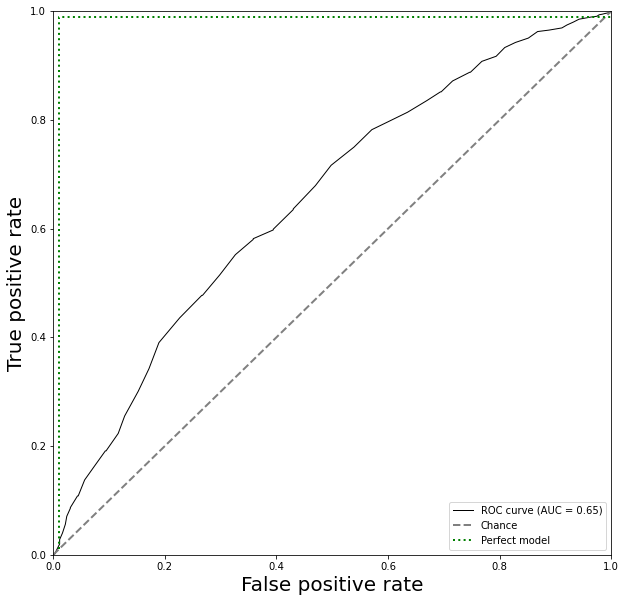

In [18]:
get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(10,10))

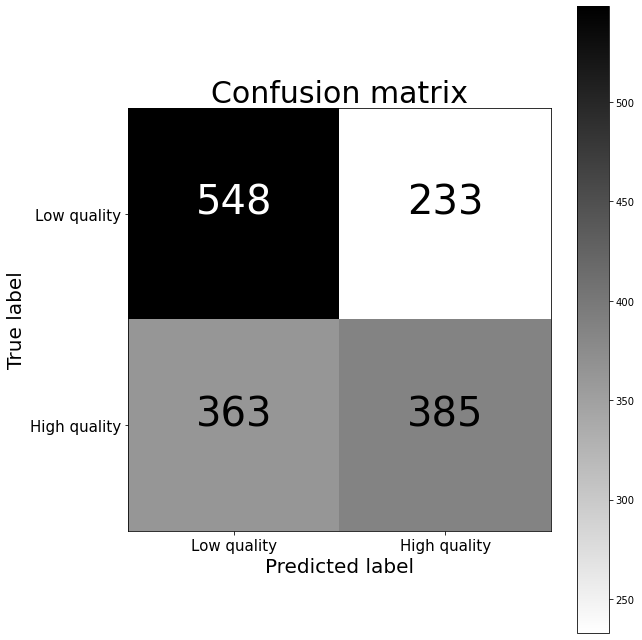

In [19]:
get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))

No handles with labels found to put in legend.


	Brier: 0.234


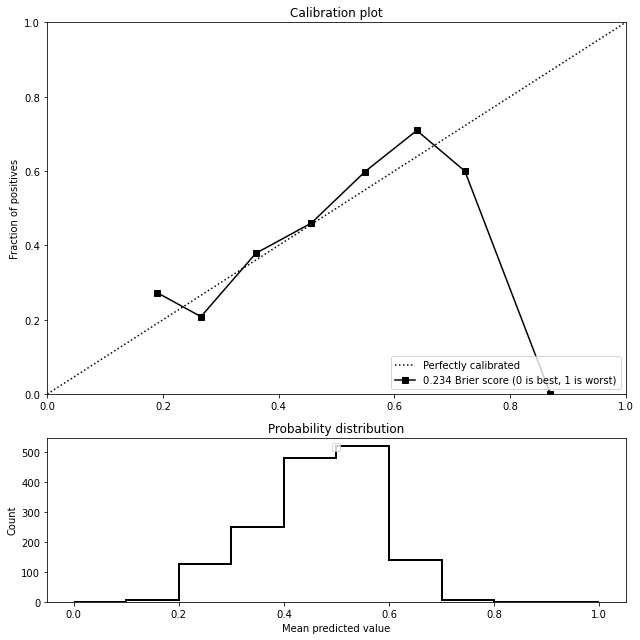

In [20]:
get_calibration_plot(y_predicted_proba[:,1], y_test, figsize=(9,9))

In [21]:
pos_prob = get_question_score_from_input("""
When quoting a person's informal speech, how much liberty do you have to make changes to what they say?
""")

print("%s probability of the question receiving a high score according to our model" % (pos_prob))

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.80it/s]

0.4 probability of the question receiving a high score according to our model
